In [48]:
import boto3
import datetime
import os
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import shutil
import tempfile

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [49]:
aws_psql_conn = psycopg2.connect(
    database=os.getenv("AWS_PSQL_DB"),
    user=os.getenv("AWS_PSQL_USER"),
    password=os.getenv("AWS_PSQL_PASSWORD"),
    host=os.getenv("AWS_PSQL_HOST"),
    port=os.getenv("AWS_PSQL_PORT"),
)

cursor = aws_psql_conn.cursor()

In [50]:
sql = f"select * from games"

cursor.execute(sql)

rows = cursor.fetchall()

column_names = [desc[0] for desc in cursor.description]

In [51]:
df = pd.DataFrame(rows, columns=column_names)

print(df.head)

<bound method NDFrame.head of      game_id  home_team_id        home_team_name  away_team_id  \
0     718780           120  Washington Nationals           144   
1     718781           147      New York Yankees           137   
2     718782           111        Boston Red Sox           110   
3     718777           112          Chicago Cubs           158   
4     718776           139        Tampa Bay Rays           116   
..       ...           ...                   ...           ...   
794   717894           140         Texas Rangers           136   
795   717890           137  San Francisco Giants           110   
796   717892           109  Arizona Diamondbacks           144   
797   717889           135      San Diego Padres           112   
798   717888           119   Los Angeles Dodgers           147   

           away_team_name        home_pitcher  home_pitcher_id  \
0          Atlanta Braves      Patrick Corbin         571578.0   
1    San Francisco Giants         Gerrit Cole

In [52]:
columns_to_remove = [
    "home_team_name",
    "away_team_name",
    "home_pitcher",
    "home_pitcher_id",
    "away_pitcher",
    "away_pitcher_id",
]

df = df.drop(columns=columns_to_remove)

print(df.head)

<bound method NDFrame.head of      game_id  home_team_id  away_team_id  home_pitcher_era  \
0     718780           120           144               NaN   
1     718781           147           137               NaN   
2     718782           111           110               NaN   
3     718777           112           158               NaN   
4     718776           139           116               NaN   
..       ...           ...           ...               ...   
794   717894           140           136              2.42   
795   717890           137           110              3.48   
796   717892           109           144              2.72   
797   717889           135           112              4.28   
798   717888           119           147              1.64   

     home_pitcher_win_percentage  home_pitcher_wins  home_pitcher_losses  \
0                            NaN                NaN                  NaN   
1                            NaN                NaN                  NaN 

In [53]:
df = df.dropna()

print(df.head)

<bound method NDFrame.head of      game_id  home_team_id  away_team_id  home_pitcher_era  \
78    718703           119           115              3.00   
79    718704           120           139              6.00   
81    718701           146           142              0.00   
84    718698           158           121              7.20   
91    718434           113           140              6.00   
..       ...           ...           ...               ...   
794   717894           140           136              2.42   
795   717890           137           110              3.48   
796   717892           109           144              2.72   
797   717889           135           112              4.28   
798   717888           119           147              1.64   

     home_pitcher_win_percentage  home_pitcher_wins  home_pitcher_losses  \
78                         1.000                1.0                  0.0   
79                         0.000                0.0                  1.0 

In [54]:
df.columns

Index(['game_id', 'home_team_id', 'away_team_id', 'home_pitcher_era',
       'home_pitcher_win_percentage', 'home_pitcher_wins',
       'home_pitcher_losses', 'home_pitcher_innings_pitched',
       'away_pitcher_era', 'away_pitcher_win_percentage', 'away_pitcher_wins',
       'away_pitcher_losses', 'away_pitcher_innings_pitched', 'winning_team',
       'home_pitcher_k_nine', 'home_pitcher_bb_nine', 'home_pitcher_k_bb_diff',
       'home_pitcher_whip', 'home_pitcher_babip', 'away_pitcher_k_nine',
       'away_pitcher_bb_nine', 'away_pitcher_k_bb_diff', 'away_pitcher_whip',
       'away_pitcher_babip'],
      dtype='object')

In [55]:
X = []
Y = []

for index, row in df.iterrows():
    pitcher_era_comp = row['away_pitcher_era'] - row['home_pitcher_era']
    pitcher_win_percentage_comp = row['away_pitcher_win_percentage'] - row['home_pitcher_win_percentage']
    pitcher_win_comp = row['away_pitcher_wins'] - row['home_pitcher_wins']
    pitcher_losses_comp = row['away_pitcher_losses'] - row['home_pitcher_losses']
    pitcher_innings_pitched_comp = row['away_pitcher_innings_pitched'] - row['home_pitcher_innings_pitched']
    pitcher_k_nine_comp = row['away_pitcher_k_nine'] - row['home_pitcher_k_nine']
    pitcher_bb_nine_comp = row['away_pitcher_bb_nine'] - row['home_pitcher_bb_nine']
    pitcher_k_bb_diff_comp = row['away_pitcher_k_bb_diff'] - row['home_pitcher_k_bb_diff']
    pitcher_whip_comp = row['away_pitcher_whip'] - row['home_pitcher_whip']
    pitcher_babip_comp = row['away_pitcher_babip'] - row['home_pitcher_babip']

    comparison = [pitcher_era_comp, pitcher_win_percentage_comp, pitcher_win_comp, pitcher_losses_comp, pitcher_innings_pitched_comp, pitcher_k_nine_comp, pitcher_bb_nine_comp, pitcher_k_bb_diff_comp, pitcher_whip_comp, pitcher_babip_comp]

    X.append(comparison)
    Y.append(1 if row['winning_team'] == row['home_team_id'] else 0)


In [56]:
# Convert the lists to NumPy arrays for compatibility with scikit-learn
X = pd.np.array(X)
Y = pd.np.array(Y)
X = X.reshape(X.shape[0], -1)

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (432, 10)
X_test shape: (108, 10)
Y_train shape: (432,)
Y_test shape: (108,)


In [58]:
# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [59]:
# Make predictions on the training set (you can use a separate test set for predictions)
pred = model.predict(X_test)

zeroes = 0
ones = 0

for item in pred:
    if item == 0:
        zeroes += 1
    elif item == 1:
        ones += 1

print(zeroes, ones)


37 71


In [60]:
# Evaluate the model's performance (e.g., accuracy, precision, recall)
accuracy = model.score(X_test, Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.5555555555555556


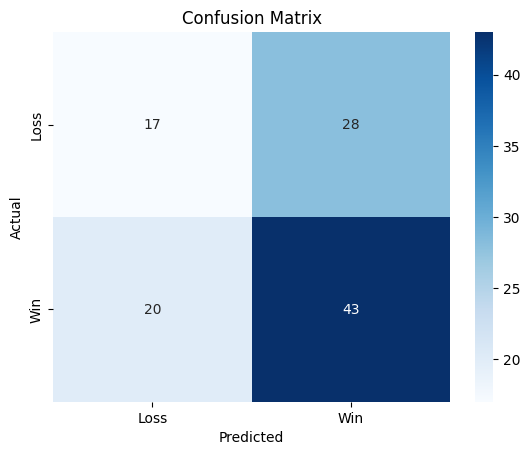

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(Y_test, pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and ticks to the plot
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Loss', 'Win'])
plt.plot(1, 1)
plt.yticks([0.5, 1.5], ['Loss', 'Win'])

# Display the plot
plt.show()

In [62]:
from sklearn.metrics import classification_report

# Generate a classification report
classification_rep = classification_report(Y_test, pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.46      0.38      0.41        45
           1       0.61      0.68      0.64        63

    accuracy                           0.56       108
   macro avg       0.53      0.53      0.53       108
weighted avg       0.54      0.56      0.55       108

